# Synthetic Data Analysis

## Data Overview

### Imports

In [41]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
import math
# from numpy.fft import fft, fftfreq
from scipy.fft import fft, fftfreq
from scipy import stats
from scipy.signal import argrelmax
from dtaidistance import dtw, dtw_ndim
from dtaidistance import dtw_visualisation as dtwvis
import struct
sns.set()

In [42]:
# Load the dataset
file_path = "acquisitions/synthetic_test/processed/processed_all_actions.csv"
ref_file_path = "acquisitions/synthetic_test/processed/processed_combined_acquisition_2024-01-14_21-20-48.csv"
# Import the CSV file into a DataFrame
df = pd.read_csv(file_path)
df_ref = pd.read_csv(ref_file_path)

# convert _time column to datetime
df['_time'] = pd.to_datetime(df['_time'])
df_ref['_time'] = pd.to_datetime(df_ref['_time'])

### Raw Data Analysis

##### Functions

In [43]:
# function to calculate correlation matrix of one series
def plot_correlation_matrix(data, action):

    # Getting the series ID for the action
    series_id = data[data['action'] == action]['series_id'].iloc[0]
    # Filter data for the specific series_id and action
    filtered_data = data[(data['series_id'] == series_id) & (data['action'] == action)]
    # Select only float columns
    numeric_data = filtered_data.select_dtypes(include=[np.float64])

    # Calculate the correlation matrix
    corr_matrix = numeric_data.corr()

    # Plotting the heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'Correlation Matrix for Series ID {series_id} and Action {action}')
    plt.show()

In [44]:
def plot_sensors_df(df, title="", x_index='sample'):
    """
    Plot the sensors data in a 4x3 subplots
    """
    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

    num_row = math.ceil(len(columns)/3)
    num_col = 3

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle(title)

    for i, column in enumerate(columns):

        if x_index == 'sample':
            axs[i//3, i%3].plot(df[column], color='C'+str(i%3), label=column)
        else:
            axs[i//3, i%3].plot(df[x_index], df[column], color='C'+str(i%3), label=column)
            
        axs[i//3, i%3].legend()
        # axs[i//3, i%3].set_title(column)

        # set the y label
        if 'accel' in column:
            axs[i//3, i%3].set_ylabel('g')
        else:
            axs[i//3, i%3].set_ylabel('deg/s')

    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

##### Code

In [45]:
df.head()

,_time,series_id,measurement_id,action,gyro_x,gyro_y,gyro_z,accel_x,accel_y,accel_z,quat_x,quat_y,quat_z,quat_w
0,2023-12-29 16:50:56.247487,0,0,floating_x,1.865854,0.323171,0.243902,0.004321,-0.004956,0.010840,-0.7,0.68,0.21,0.1
1,2023-12-29 16:50:56.262481,0,1,floating_x,1.865854,0.323171,0.243902,0.004321,-0.004956,0.010840,-0.7,0.68,0.21,0.1
2,2023-12-29 16:50:56.276026,0,2,floating_x,1.743902,-0.164634,0.182927,0.004077,0.000659,0.006201,-0.7,0.68,0.21,0.1
3,2023-12-29 16:50:56.291837,0,3,floating_x,0.280488,-1.506098,0.243902,0.003345,-0.003735,-0.007471,-0.7,0.68,0.21,0.1
4,2023-12-29 16:50:56.306791,0,4,floating_x,-0.878049,-1.567073,-0.060976,0.004565,-0.008130,-0.011377,-0.7,0.68,0.21,0.1


In [46]:
df.describe()

,_time,series_id,measurement_id,gyro_x,gyro_y,gyro_z,accel_x,accel_y,accel_z,quat_x,quat_y,quat_z,quat_w
count,3457,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000
mean,2023-12-29 16:57:36.316104448,5.216951,170.265259,-4.114510,0.755942,-0.869745,-0.106049,-0.097238,0.046940,0.051449,0.272953,0.070223,0.254709
min,2023-12-29 16:49:52.689785,0.000000,0.000000,-777.884146,-337.158537,-232.682927,-1.948242,-2.094897,-0.991528,-0.980000,-0.980000,-0.990000,0.000000
25%,2023-12-29 16:52:47.497299968,2.000000,72.000000,-8.073171,-9.926829,-15.280488,-0.266504,-0.099365,-0.023169,-0.610000,-0.210000,-0.170000,0.070000
50%,2023-12-29 16:56:23.786156032,5.000000,149.000000,0.146341,0.030488,-0.146341,-0.001611,-0.008472,0.007153,0.210000,0.530000,0.100000,0.180000
75%,2023-12-29 17:02:53.938644992,9.000000,248.000000,15.128049,10.182927,6.024390,0.033301,0.009595,0.091650,0.640000,0.690000,0.320000,0.430000
max,2023-12-29 17:08:48.633000,11.000000,500.000000,203.975610,576.463415,715.134146,1.710742,0.819019,2.023047,0.990000,0.990000,1.000000,0.970000
std,NaN,3.722790,121.300390,71.090067,74.537029,65.122563,0.437289,0.338756,0.441120,0.630403,0.530645,0.357432,0.216536


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457 entries, 0 to 3456
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   _time           3457 non-null   datetime64[ns]
 1   series_id       3457 non-null   int64         
 2   measurement_id  3457 non-null   int64         
 3   action          3457 non-null   object        
 4   gyro_x          3457 non-null   float64       
 5   gyro_y          3457 non-null   float64       
 6   gyro_z          3457 non-null   float64       
 7   accel_x         3457 non-null   float64       
 8   accel_y         3457 non-null   float64       
 9   accel_z         3457 non-null   float64       
 10  quat_x          3457 non-null   float64       
 11  quat_y          3457 non-null   float64       
 12  quat_z          3457 non-null   float64       
 13  quat_w          3457 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(2), object(1)
m

In [48]:
# groupby by action
df_grouped = df.groupby('action')

# Grouping data by series_id and action
df_grouped_id = df.groupby(['series_id', 'action']).size().unstack(fill_value=0)
# show all the actions
# print(df_grouped.groups.keys())

Check how many samples there are in each sequence.

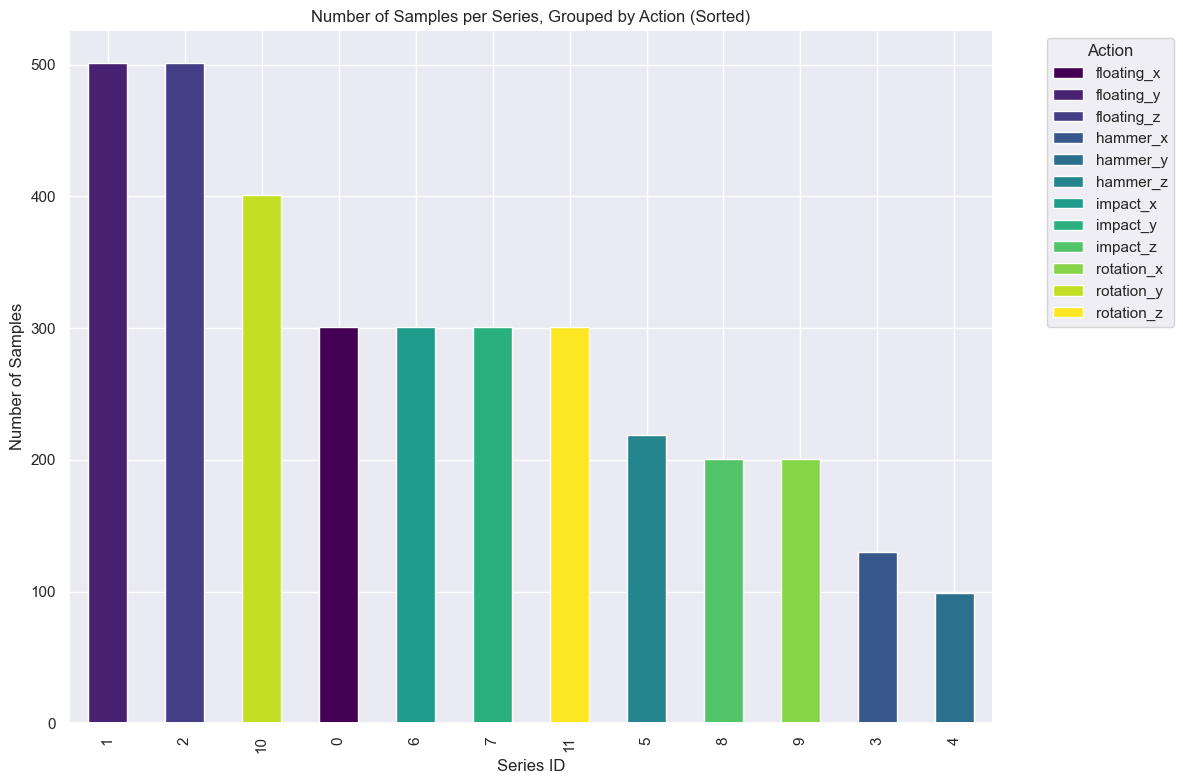

In [49]:

# Sorting the grouped data by the total number of samples in each series, from highest to lowest
sorted_grouped_data = df_grouped_id.sum(axis=1).sort_values(ascending=False)
sorted_grouped_data = df_grouped_id.loc[sorted_grouped_data.index]

# Plotting the sorted histogram
ax = sorted_grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Number of Samples per Series, Grouped by Action (Sorted)')
plt.xlabel('Series ID')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

Correlation matrix to see the relations among features for each sequence

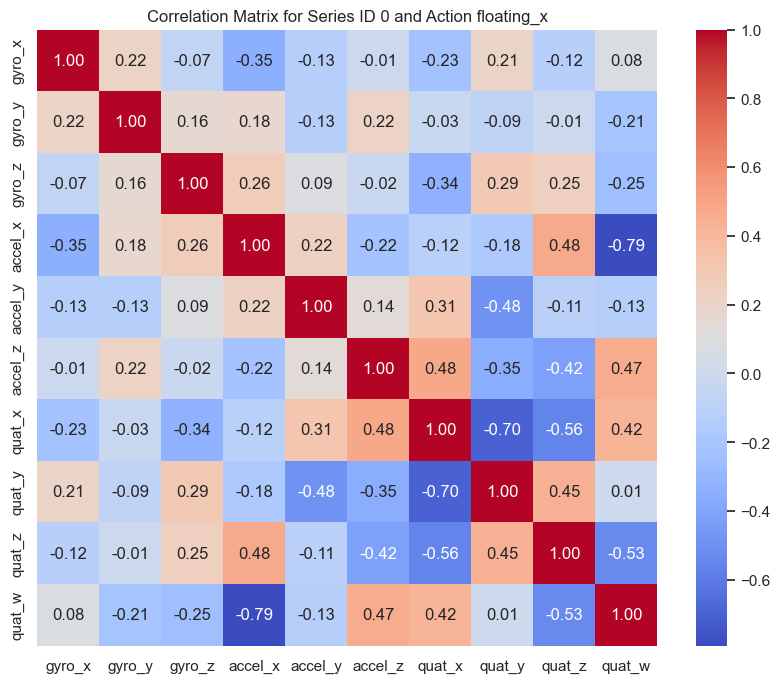

In [50]:
plot_correlation_matrix(df,'floating_x')
# plot_correlation_matrix(df,'floating_y')
# plot_correlation_matrix(df,'floating_z')
# plot_correlation_matrix(df,'hammer_x')
# plot_correlation_matrix(df,'hammer_y')
# plot_correlation_matrix(df,'hammer_z')
# plot_correlation_matrix(df,'impact_x')
# plot_correlation_matrix(df,'impact_y')
# plot_correlation_matrix(df,'impact_z')
# plot_correlation_matrix(df,'rotation_x')
# plot_correlation_matrix(df,'rotation_y')
# plot_correlation_matrix(df,'rotation_z')


In [51]:
df_time = df.copy()
df_time['time_diff'] = df_time.groupby('series_id')['_time'].diff()
df_time = df_time.dropna()
df_time['time_diff_seconds'] = df_time['time_diff'].dt.total_seconds()

Visualize the sampling time difference distribution for each sequence

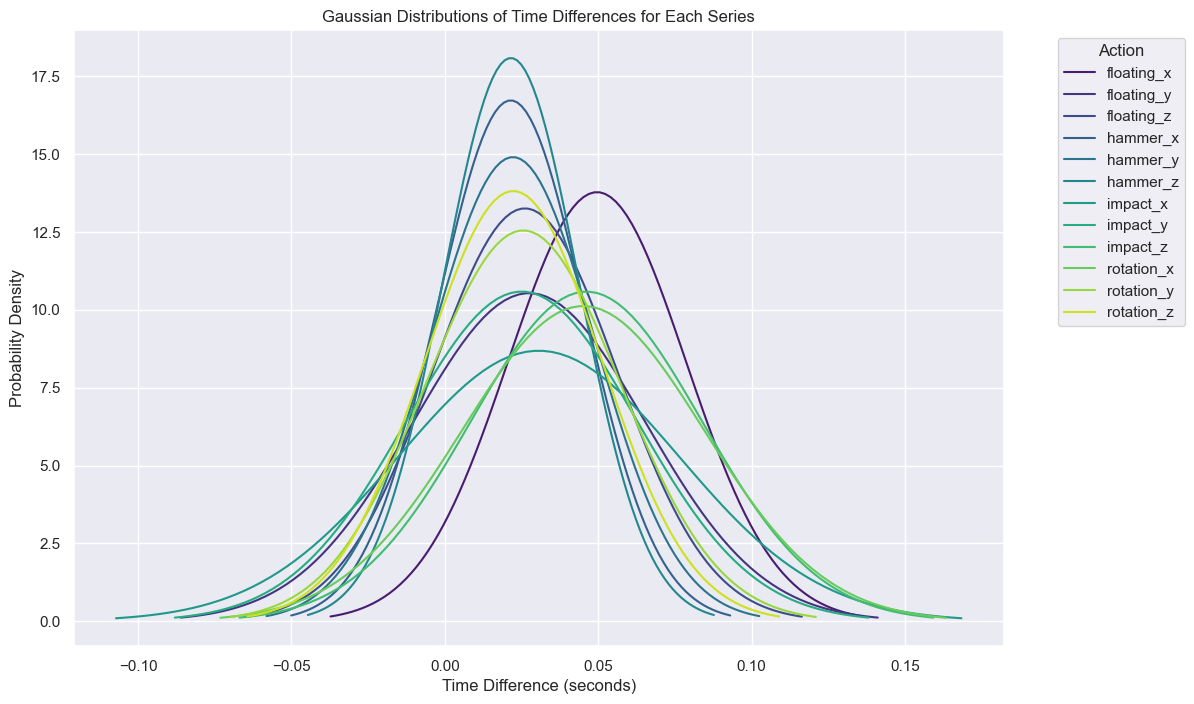

-------------------
Minimum mean: 0.021462023255813957
Maximum mean: 0.04959692666666667
Minimum std: 0.022060028831696925
Maximum std: 0.045933133781250725
-------------------
Slowest sampling time: 0.05 seconds
Fastest sampling time: 0.02 seconds


In [52]:
# Create a mapping of series_id to action
action_mapping = df_time.dropna().groupby('series_id')['action'].first().to_dict()

# Setting up the color palette to match the histogram colors
palette = sns.color_palette('viridis', n_colors=len(df_time['series_id'].unique()))

# Plotting Gaussian distributions with the same colors as the histogram
plt.figure(figsize=(12, 8))

# Generating Gaussian plots for each series
for idx, series_id in enumerate(sorted(df_time['series_id'].unique())):
    # Selecting the series
    series_data = df_time[df_time['series_id'] == series_id]['time_diff_seconds']
    
    # Calculating mean and standard deviation
    mean = series_data.mean()
    std = series_data.std()
    
    # Generating points for the Gaussian curve
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    
    # Plotting with action name in the label
    action_name = action_mapping.get(series_id, 'Unknown')
    plt.plot(x, y, label=f'{action_name}', color=palette[idx])

# Adding title, labels, and legend
plt.title('Gaussian Distributions of Time Differences for Each Series')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Probability Density')
plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
# show bar on top of grid
plt.gca().set_axisbelow(True)
# Show plot
plt.show()

# print the mean and standard deviation of the time differences for each series
series_mean = []
series_std = []

for series_id in df_time['series_id'].unique():
    series_data = df_time[df_time['series_id'] == series_id]['time_diff_seconds']
    series_mean.append(series_data.mean())
    series_std.append(series_data.std())
    # print(f'Series {series_id}: mean = {series_data.mean()}, std = {series_data.std()}')

print('-------------------')

# print minimum and maximum mean and standard deviation
print(f'Minimum mean: {min(series_mean)}')
print(f'Maximum mean: {max(series_mean)}')
print(f'Minimum std: {min(series_std)}')
print(f'Maximum std: {max(series_std)}')

print('-------------------')

print(f'Slowest sampling time: {round(max(series_mean), 2)} seconds')
print(f'Fastest sampling time: {round(min(series_mean), 2)} seconds')

In [53]:
df_floatingx = df_grouped.get_group('floating_x')
df_floatingy = df_grouped.get_group('floating_y')
df_floatingz = df_grouped.get_group('floating_z')
df_hammerx = df_grouped.get_group('hammer_x')
df_hammery = df_grouped.get_group('hammer_y')
df_hammerz = df_grouped.get_group('hammer_z')
df_impactx = df_grouped.get_group('impact_x')
df_impacty = df_grouped.get_group('impact_y')
df_impactz = df_grouped.get_group('impact_z')
df_rotationx = df_grouped.get_group('rotation_x')
df_rotationy = df_grouped.get_group('rotation_y')
df_rotationz = df_grouped.get_group('rotation_z')

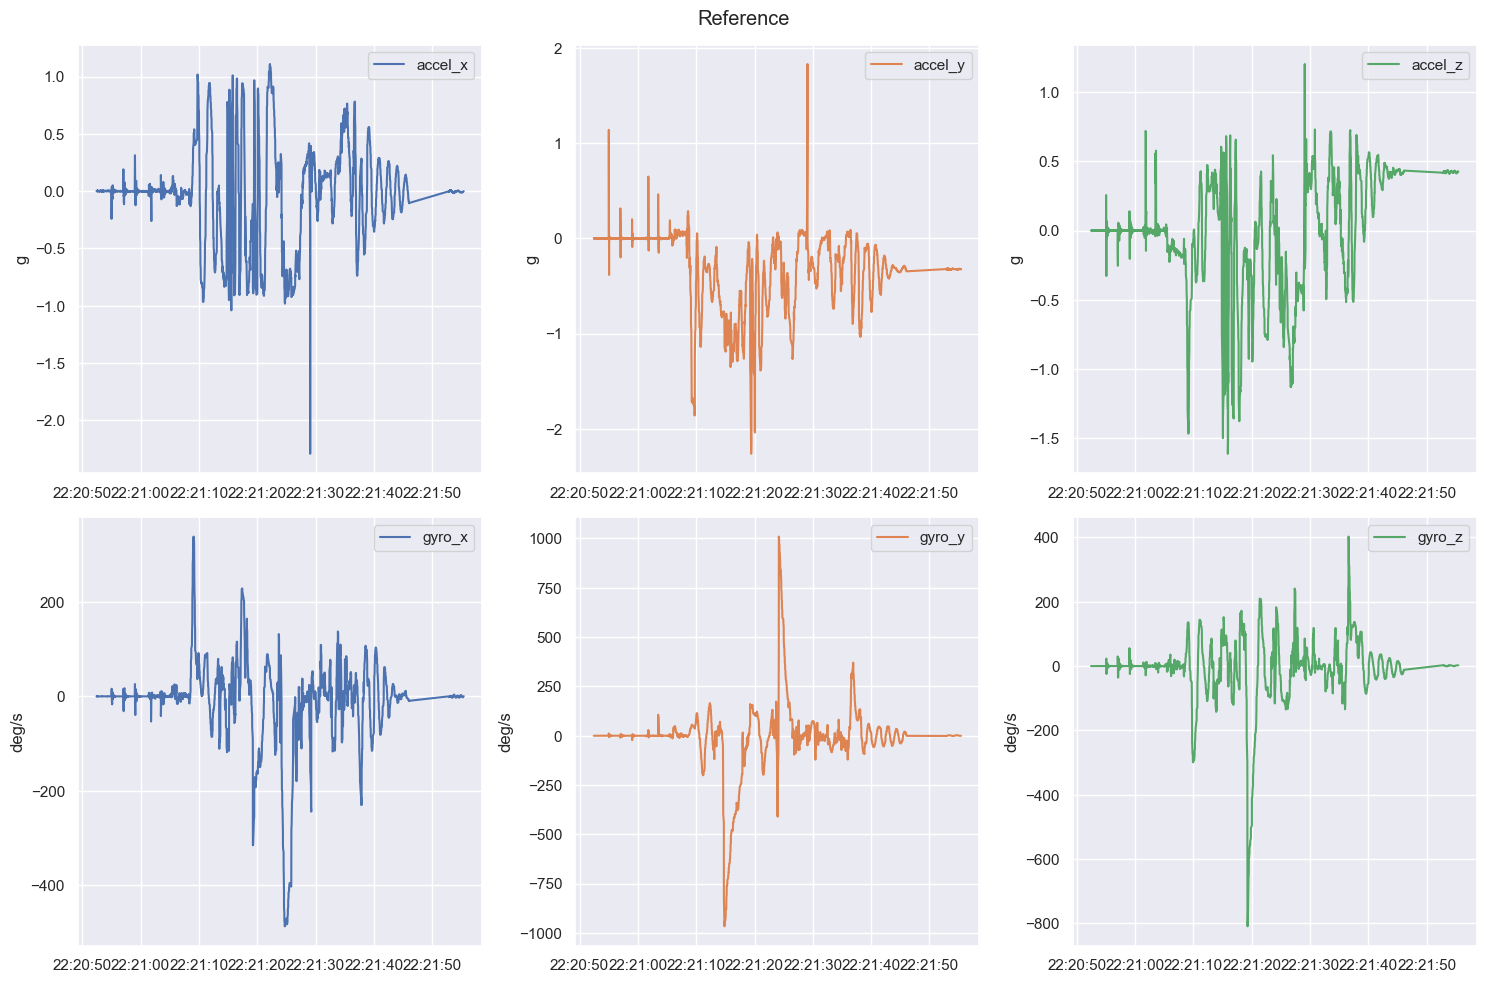

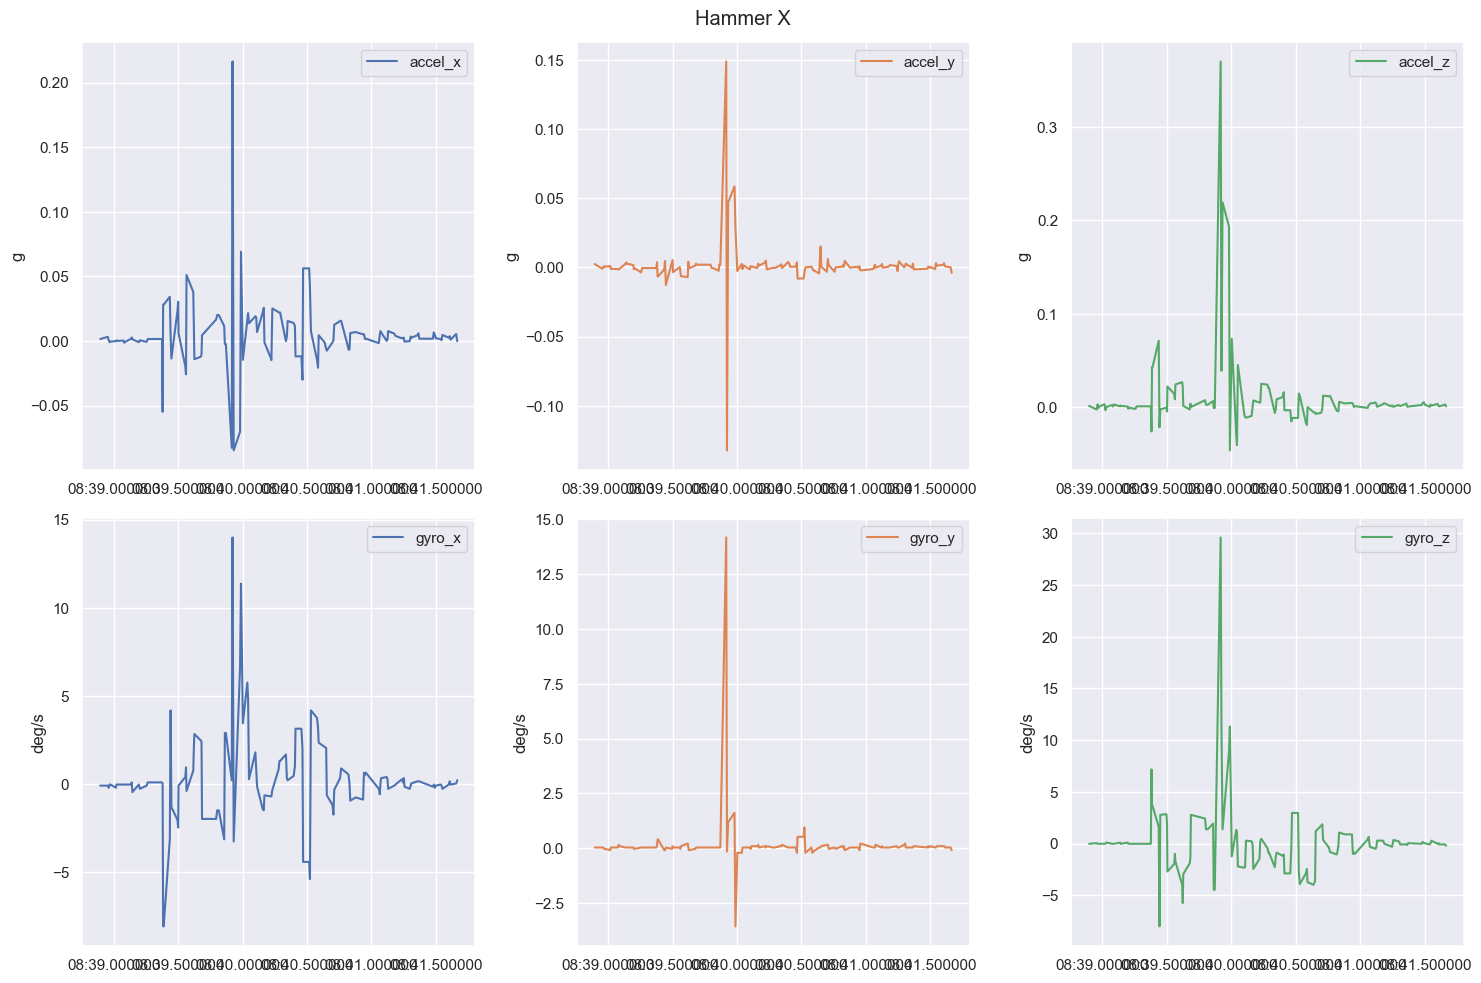

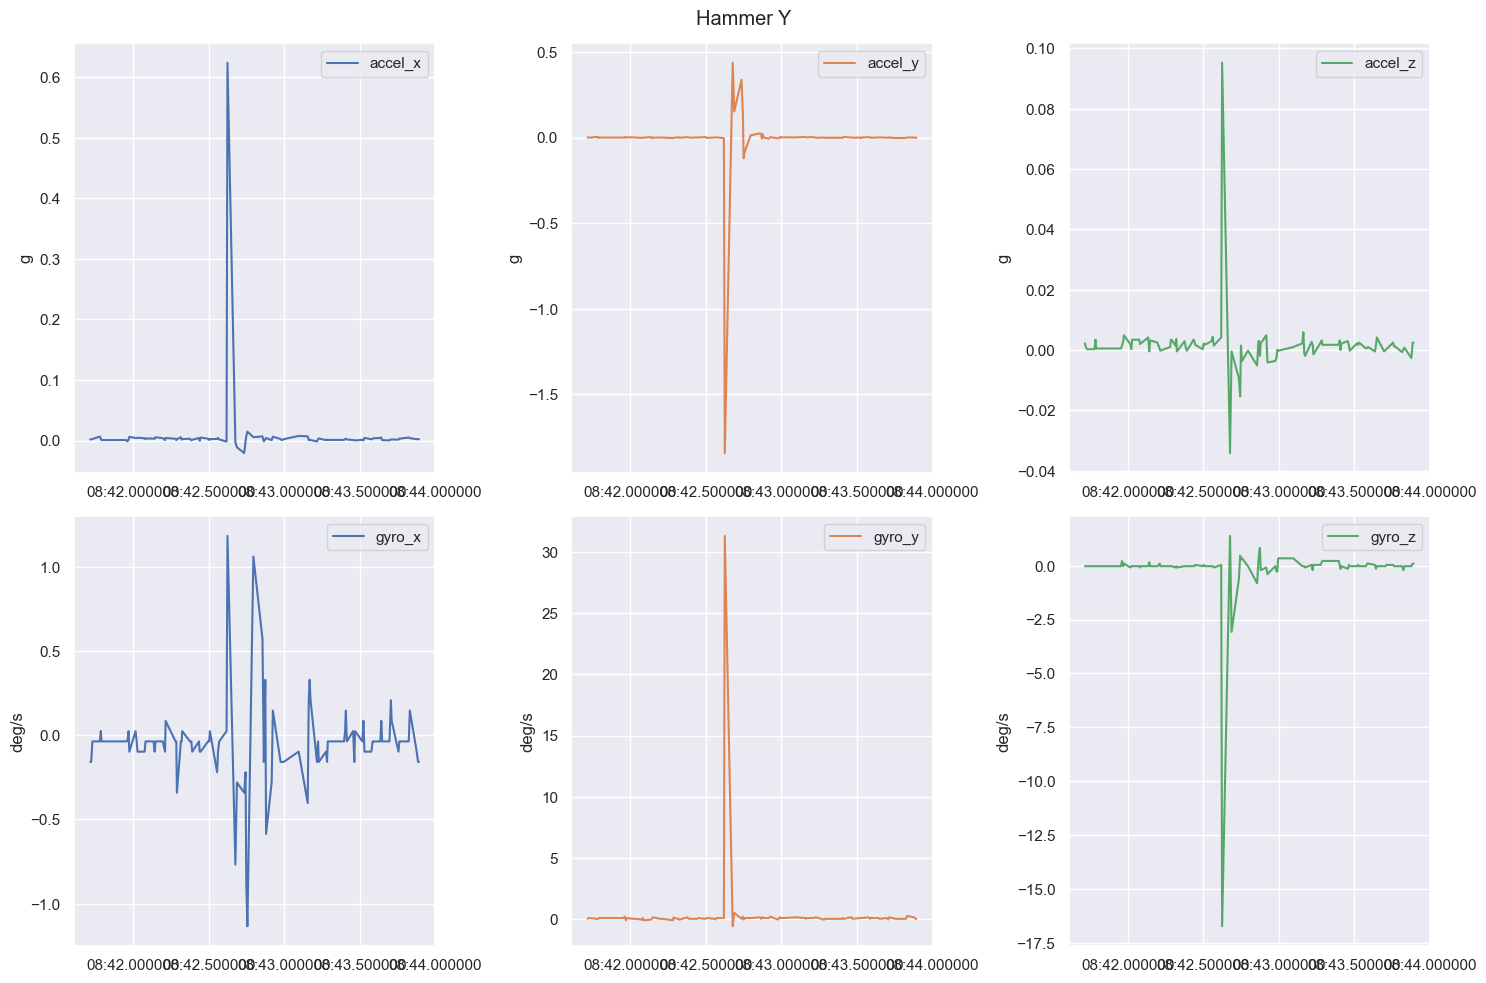

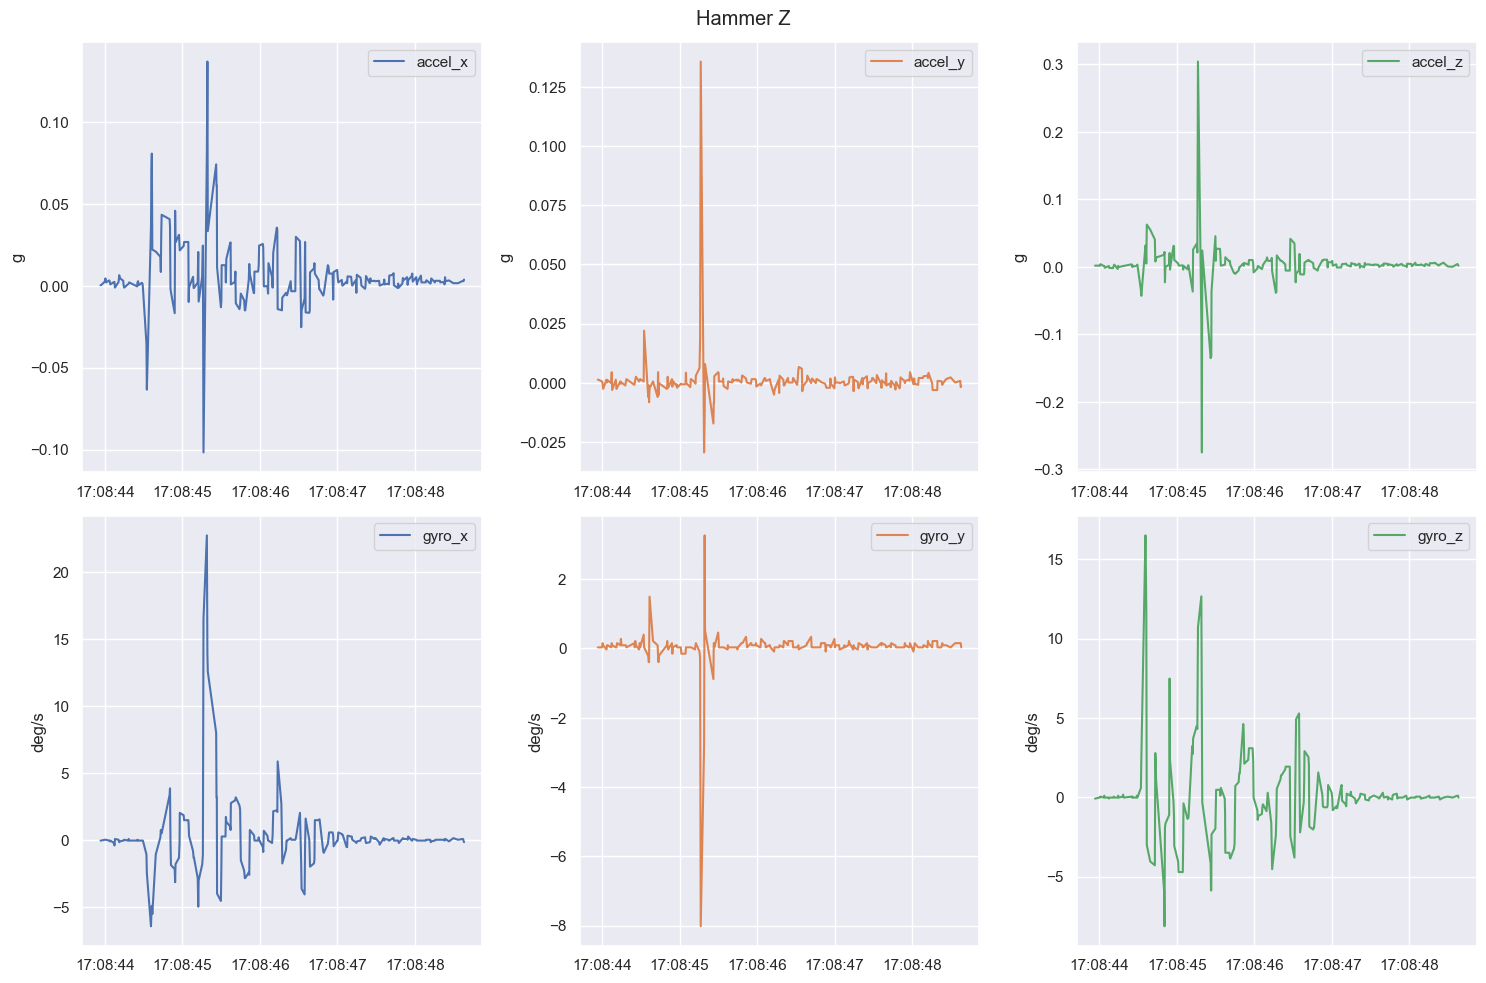

In [54]:
# plot reference data
plot_sensors_df(df_ref, "Reference", x_index='_time')

# plot all the actions

# plot_sensors_df(df_floatingx, "Floating X", x_index='_time')
# plot_sensors_df(df_floatingy, "Floating Y", x_index='_time')
# plot_sensors_df(df_floatingz, "Floating Z", x_index='_time')
plot_sensors_df(df_hammerx, "Hammer X", x_index='_time')
plot_sensors_df(df_hammery, "Hammer Y", x_index='_time')
plot_sensors_df(df_hammerz, "Hammer Z", x_index='_time')
# plot_sensors_df(df_impactx, "Impact X", x_index='_time')
# plot_sensors_df(df_impacty, "Impact Y", x_index='_time')
# plot_sensors_df(df_impactz, "Impact Z", x_index='_time')
# plot_sensors_df(df_rotationx, "Rotation X", x_index='_time')
# plot_sensors_df(df_rotationy, "Rotation Y", x_index='_time')
# plot_sensors_df(df_rotationz, "Rotation Z", x_index='_time')

## Data Manipulation

### Re-sampling

In [7]:
# resample the dataset to 0.01s
sampling_time = 0.01

# keep only columns=['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
columns=['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'quat_x', 'quat_y', 'quat_z', 'quat_w']
df_ref_over = df_ref[columns].copy()
df_floatinx_over = df_floatingx[columns].copy()
df_floatiny_over = df_floatingy[columns].copy()
df_floatinz_over = df_floatingz[columns].copy()
df_hammerx_over = df_hammerx[columns].copy()
df_hammery_over = df_hammery[columns].copy()
df_hammerz_over = df_hammerz[columns].copy()
df_impactx_over = df_impactx[columns].copy()
df_impacty_over = df_impacty[columns].copy()
df_impactz_over = df_impactz[columns].copy()
df_rotationx_over = df_rotationx[columns].copy()
df_rotationy_over = df_rotationy[columns].copy()
df_rotationz_over = df_rotationz[columns].copy()

# resample the dataset
df_ref_over = df_ref_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_floatinx_over = df_floatinx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_floatiny_over = df_floatiny_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_floatinz_over = df_floatinz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_hammerx_over = df_hammerx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_hammery_over = df_hammery_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_hammerz_over = df_hammerz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_impactx_over = df_impactx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_impacty_over = df_impacty_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_impactz_over = df_impactz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_rotationx_over = df_rotationx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_rotationy_over = df_rotationy_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_rotationz_over = df_rotationz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')

# get smallest length
min_window_length = min(len(df_floatinx_over), len(df_floatiny_over), len(df_floatinz_over), len(df_hammerx_over), len(df_hammery_over), len(df_hammerz_over), len(df_impactx_over), len(df_impacty_over), len(df_impactz_over), len(df_rotationx_over), len(df_rotationy_over), len(df_rotationz_over))
max_window_length = max(len(df_floatinx_over), len(df_floatiny_over), len(df_floatinz_over), len(df_hammerx_over), len(df_hammery_over), len(df_hammerz_over), len(df_impactx_over), len(df_impacty_over), len(df_impactz_over), len(df_rotationx_over), len(df_rotationy_over), len(df_rotationz_over))

### FFT

##### Functions

In [8]:
def get_fft_peaks(df, sampling_time, title="", plot=False, window=0, shift=0):
    """Get the fft peaks of the dataframe

    Args:
        df (): pandas dataframe
        sampling_time (float): sampling time
        title (str, optional): title of the plot. Defaults to "".
        plot (bool, optional): plot the fft. Defaults to False.
        window (int, optional): number of samples to split the dataframe and calculate the fft on each window. Defaults to 0.
        shift (int, optional): number of samples to shift the window and recalculate the fft. Defaults to 0.

    Returns:
        data_struct: struct with fft values, frequency and peaks
    """
    
    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    num_row = math.ceil(len(columns)/3)
    num_col = 3

    num_peaks = 5
    order_peaks = 8
    
    df_window = []
    if window > 0:
        # get a new index before resampling
        df = df.reset_index(drop=True)
    
        # split the dataframe in windows of size window, every new window is shifted by shift from the last sample of the previous window
        for i in range(0, len(df), shift):
            # if the size of the window is less than window, add 0 paddings
            if i+window > len(df):
                diff = i+window - len(df)
                padded_window = df[i:].copy()
                padded_window = padded_window.reindex(range(diff), fill_value=0.0)
                # start the index from the last sample of the previous window
                last_index = df[i:].index[-1]
                padded_window.index = range(last_index+1, last_index+1+diff)
                # add the padded window to the list
                padded_window = pd.concat([df[i:], padded_window])
                df_window.append(padded_window)
            else:
                df_window.append(df[i:i+window])
    else:
        df_window.append(df)

    # print("Number of windows: ", len(df_window))
    # print(df_window)     

    # create struct to return
    data_struct = {}

    for i in range(len(df_window)):
        # add a new key to the struct
        data_struct[i] = {}

    if plot:
        fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
        fig.suptitle("FFT with peaks " + title)
    
    for i, df in enumerate(df_window):
        # print("Window: ", i)
        # print(df)
        # variable to store the accel and gyro peak values
        accel_peak_values = []
        gyro_peak_values = []
        # variable to store the accel and gyro peak frequencies
        accel_peak_freq = []
        gyro_peak_freq = []

        for j, column in enumerate(columns):
            # get the fft
            fft_values = fft(df[column].values)
            # get the frequency
            freq = fftfreq(len(df[column].values), d=sampling_time)
            # get the peaks
            peaks = argrelmax(np.abs(fft_values[freq>=0]), order=order_peaks)[0]
            while len(peaks) < num_peaks and order_peaks > 1:
                # reduce the order
                order_peaks = order_peaks - 1
                # get the peaks
                peaks = argrelmax(np.abs(fft_values[freq>=0]), order=order_peaks)[0]
            
            # take the top 5 peaks which are greater than 0
            peaks = peaks[np.argsort(np.abs(fft_values[freq>=0][peaks]))[-5:]]
            # sort the peaks
            peaks.sort()
            # update the struct
            data_struct[i][column] = {'fft_values': fft_values, 'freq': freq, 'peaks': peaks}

            # add the peaks to the list
            if 'accel' in column:
                accel_peak_values.append(np.abs(fft_values[freq>=0][peaks]))
                accel_peak_freq.append(freq[peaks])
            else:
                gyro_peak_values.append(np.abs(fft_values[freq>=0][peaks]))
                gyro_peak_freq.append(freq[peaks])

            if plot:
                # plot the fft
                axs[j//3, j%3].plot(freq[freq>=0], np.abs(fft_values[freq>=0]), color='C'+str(j%3), label=column)
                # plot the peaks
                axs[j//3, j%3].plot(freq[peaks], np.abs(fft_values[freq>=0][peaks]), 'x', color='red', label='peaks')
                if window == 0:
                    axs[j//3, j%3].legend()

                # set the y label
                if 'accel' in column:
                    axs[j//3, j%3].set_ylabel('g')
                else:
                    axs[j//3, j%3].set_ylabel('deg/s')
        
        # concatenate the peaks
        accel_peak_values = np.concatenate(accel_peak_values)
        gyro_peak_values = np.concatenate(gyro_peak_values)
        accel_peak_freq = np.concatenate(accel_peak_freq)
        gyro_peak_freq = np.concatenate(gyro_peak_freq)
        # check if there are duplicated frequencies and remove them together with the values
        accel_peak_freq, index = np.unique(accel_peak_freq, return_index=True)
        accel_peak_values = accel_peak_values[index]
        gyro_peak_freq, index = np.unique(gyro_peak_freq, return_index=True)
        gyro_peak_values = gyro_peak_values[index]
        # sort the peaks
        accel_peak_values = accel_peak_values[np.argsort(accel_peak_freq)]
        gyro_peak_values = gyro_peak_values[np.argsort(gyro_peak_freq)]
        accel_peak_freq = accel_peak_freq[np.argsort(accel_peak_freq)]
        gyro_peak_freq = gyro_peak_freq[np.argsort(gyro_peak_freq)]

        # add the peaks to the struct
        data_struct[i]['accel_peaks'] = accel_peak_values
        data_struct[i]['accel_peaks_freq'] = accel_peak_freq
        data_struct[i]['gyro_peaks'] = gyro_peak_values
        data_struct[i]['gyro_peaks_freq'] = gyro_peak_freq

    return data_struct

In [9]:
def plot_stem_peaks(sensor_fft, title=""):

    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    num_row = math.ceil(len(columns)/3)
    num_col = 3

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle("FFT Peaks - "+title)

    for i, column in enumerate(columns):
        # stem plot
        axs[i//3, i%3].stem(sensor_fft[column]['freq'][sensor_fft[column]['peaks']], np.abs(sensor_fft[column]['fft_values'][sensor_fft[column]['peaks']]), label=column, basefmt='C'+str(i%3), linefmt='C'+str(i%3))
        axs[i//3, i%3].plot(sensor_fft[column]['freq'][sensor_fft[column]['peaks']], np.abs(sensor_fft[column]['fft_values'][sensor_fft[column]['peaks']]), label=column, color='C'+str(i%3), alpha=0.5)
        
        # set the y label
        if 'accel' in column:
            axs[i//3, i%3].set_ylabel('g')
        else:
            axs[i//3, i%3].set_ylabel('deg/s')
            axs[i//3, i%3].set_xlabel('Hz')

        axs[i//3, i%3].legend()


    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

In [10]:
def plot_peaks_combined(sensor_struct, title=""):

    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle("FFT Peaks - "+title)

    axs[0].stem(sensor_struct['accel_peaks_freq'], sensor_struct['accel_peaks'], label='accel_xyz', basefmt='C0', linefmt='C0')
    axs[0].plot(sensor_struct['accel_peaks_freq'], sensor_struct['accel_peaks'], label='accel_xyz', color='C0', alpha=0.5)
    axs[1].stem(sensor_struct['gyro_peaks_freq'], sensor_struct['gyro_peaks'], label='gyro_xyz', basefmt='C1', linefmt='C1')
    axs[1].plot(sensor_struct['gyro_peaks_freq'], sensor_struct['gyro_peaks'], label='gyro_xyz', color='C1', alpha=0.5)

    axs[0].set_ylabel('g')
    axs[1].set_ylabel('deg/s')
    axs[1].set_xlabel('Hz')

    axs[0].legend()
    axs[1].legend()
    
    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

In [11]:
# zip peaks and frequencies
def zip_peaks_freq(freq, peaks):
    return np.array(list(zip(freq, peaks)))

##### Code

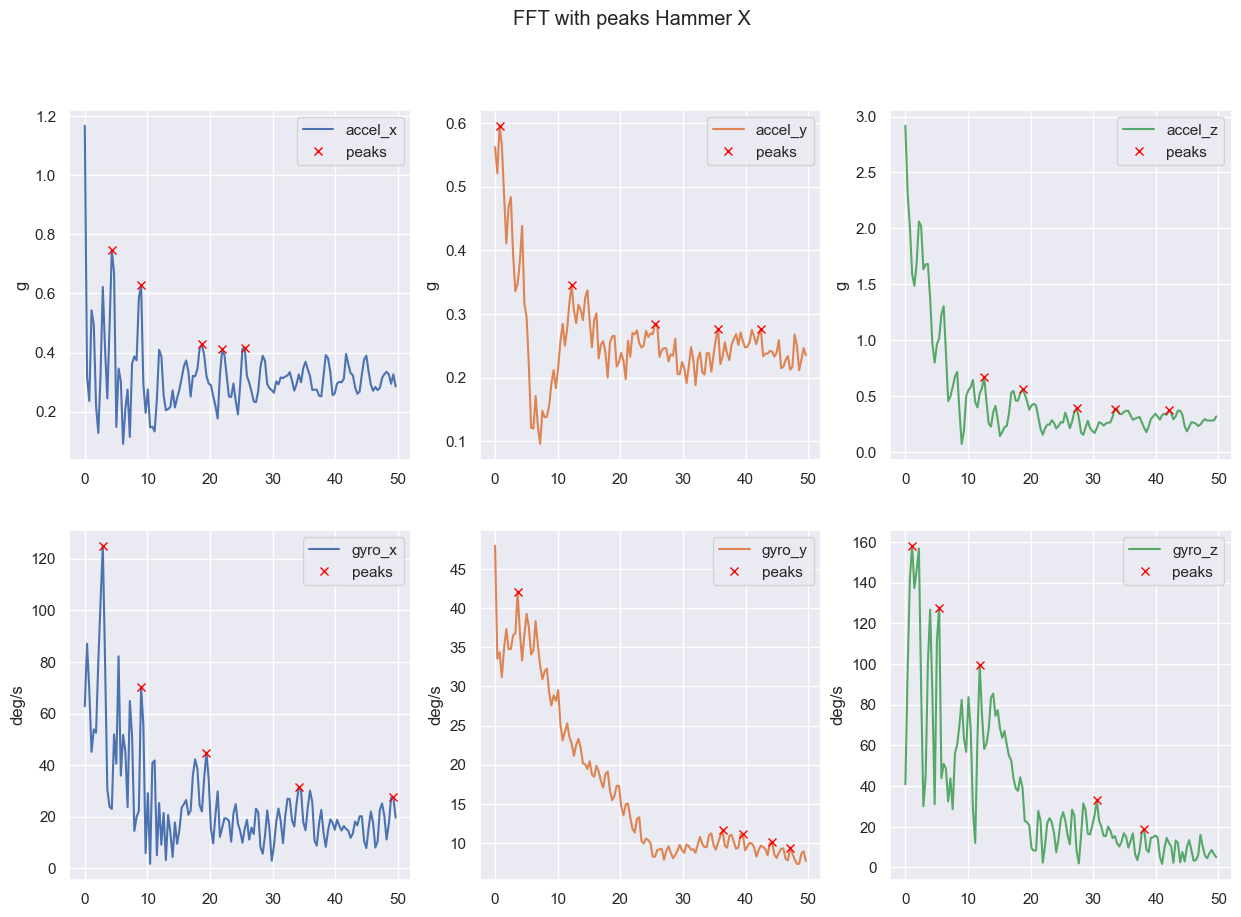

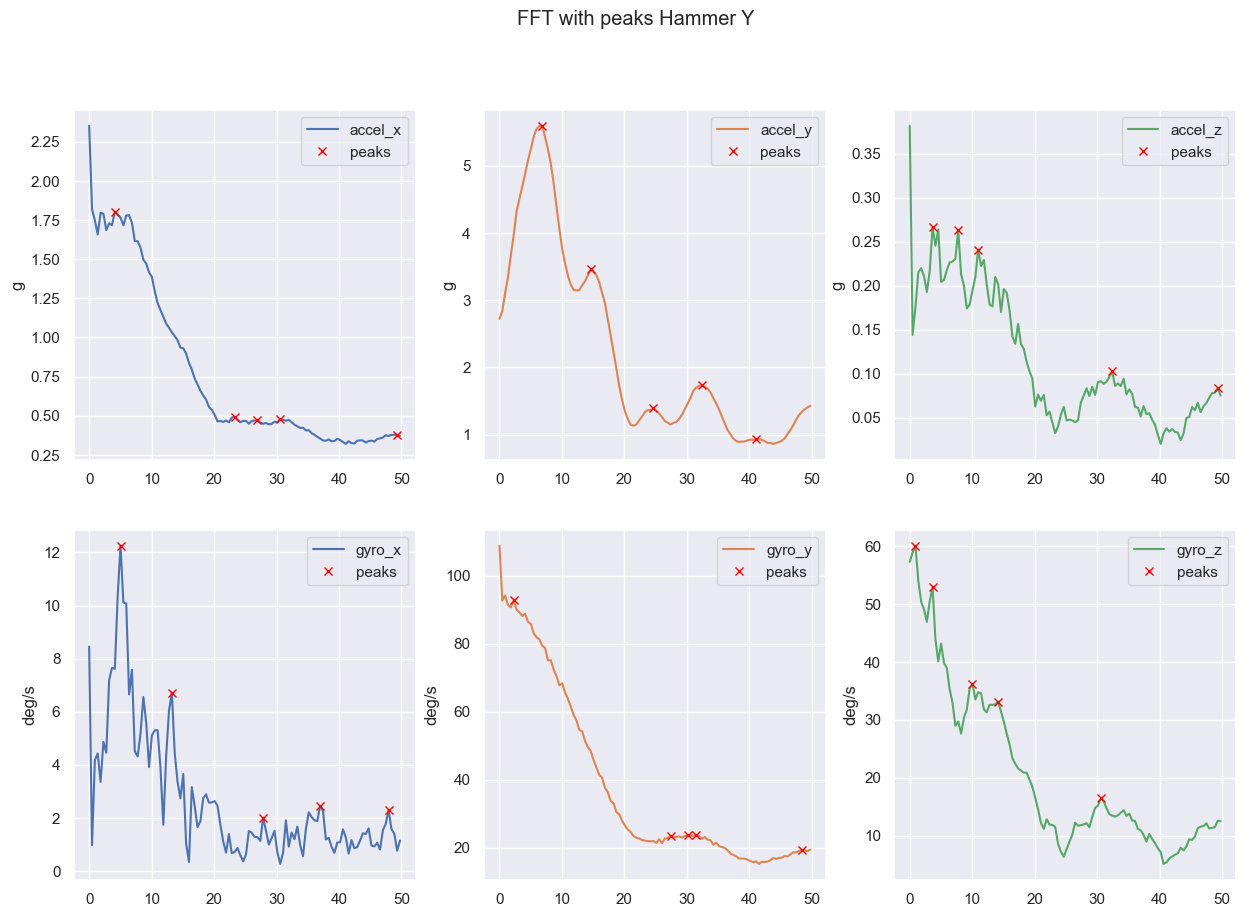

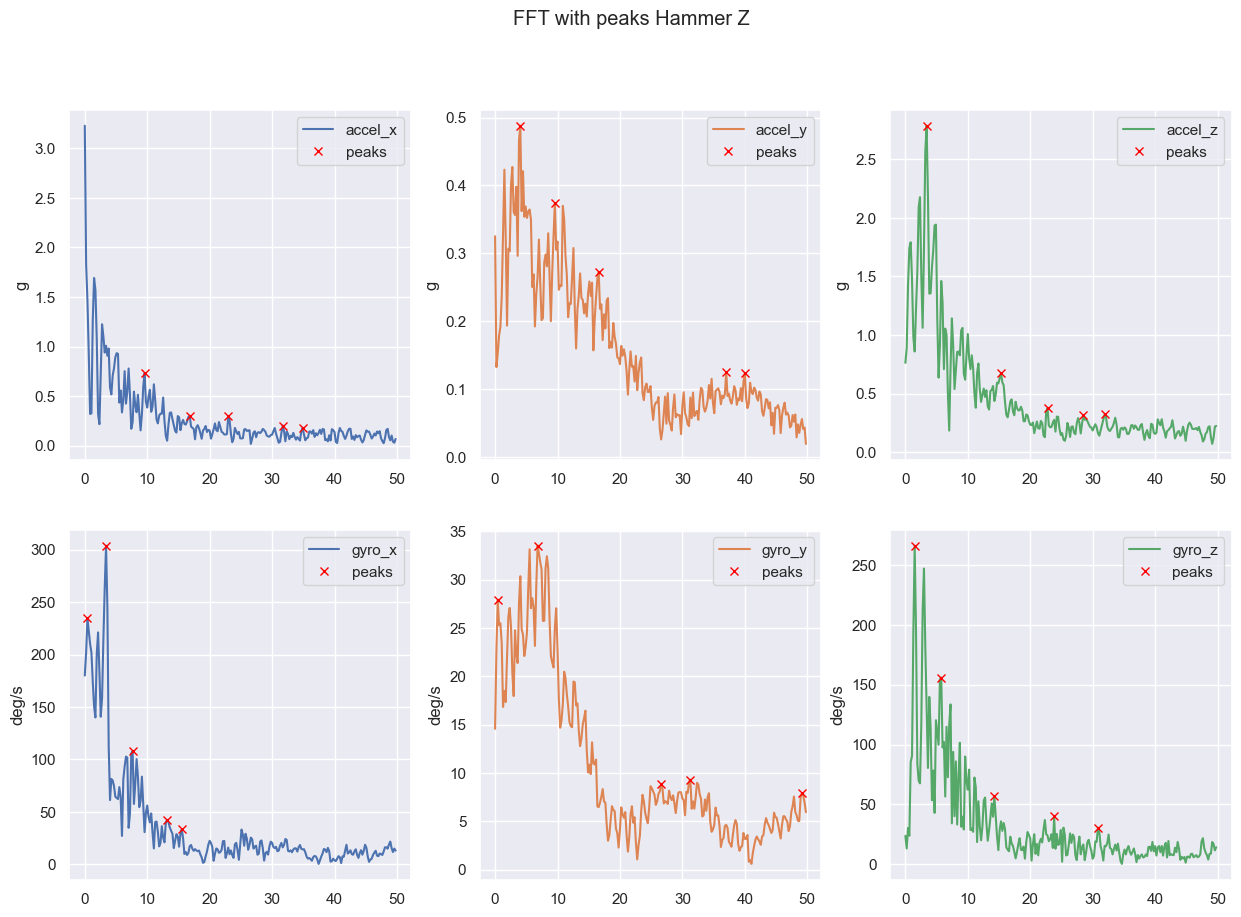

In [12]:
# ref_fft = get_fft_peaks(df_ref_over, sampling_time, title="Reference", plot=False, window=min_window_length, shift=2)
ref_fft = get_fft_peaks(df_ref_over, sampling_time, title="Reference", plot=False, window=max_window_length, shift=20)
floatingx_fft = get_fft_peaks(df_floatinx_over, sampling_time, title="Floating X", plot=False)
floatingy_fft = get_fft_peaks(df_floatiny_over, sampling_time, title="Floating Y", plot=False)
floatingz_fft = get_fft_peaks(df_floatinz_over, sampling_time, title="Floating Z", plot=False)
hammerx_fft = get_fft_peaks(df_hammerx_over, sampling_time, title="Hammer X", plot=True)
hammery_fft = get_fft_peaks(df_hammery_over, sampling_time, title="Hammer Y", plot=True)
hammerz_fft = get_fft_peaks(df_hammerz_over, sampling_time, title="Hammer Z", plot=True)
impactx_fft = get_fft_peaks(df_impactx_over, sampling_time, title="Impact X", plot=False)
impacty_fft = get_fft_peaks(df_impacty_over, sampling_time, title="Impact Y", plot=False)
impactz_fft = get_fft_peaks(df_impactz_over, sampling_time, title="Impact Z", plot=False)
rotationx_fft = get_fft_peaks(df_rotationx_over, sampling_time, title="Rotation X", plot=False)
rotationy_fft = get_fft_peaks(df_rotationy_over, sampling_time, title="Rotation Y", plot=False)
rotationz_fft = get_fft_peaks(df_rotationz_over, sampling_time, title="Rotation Z", plot=False)

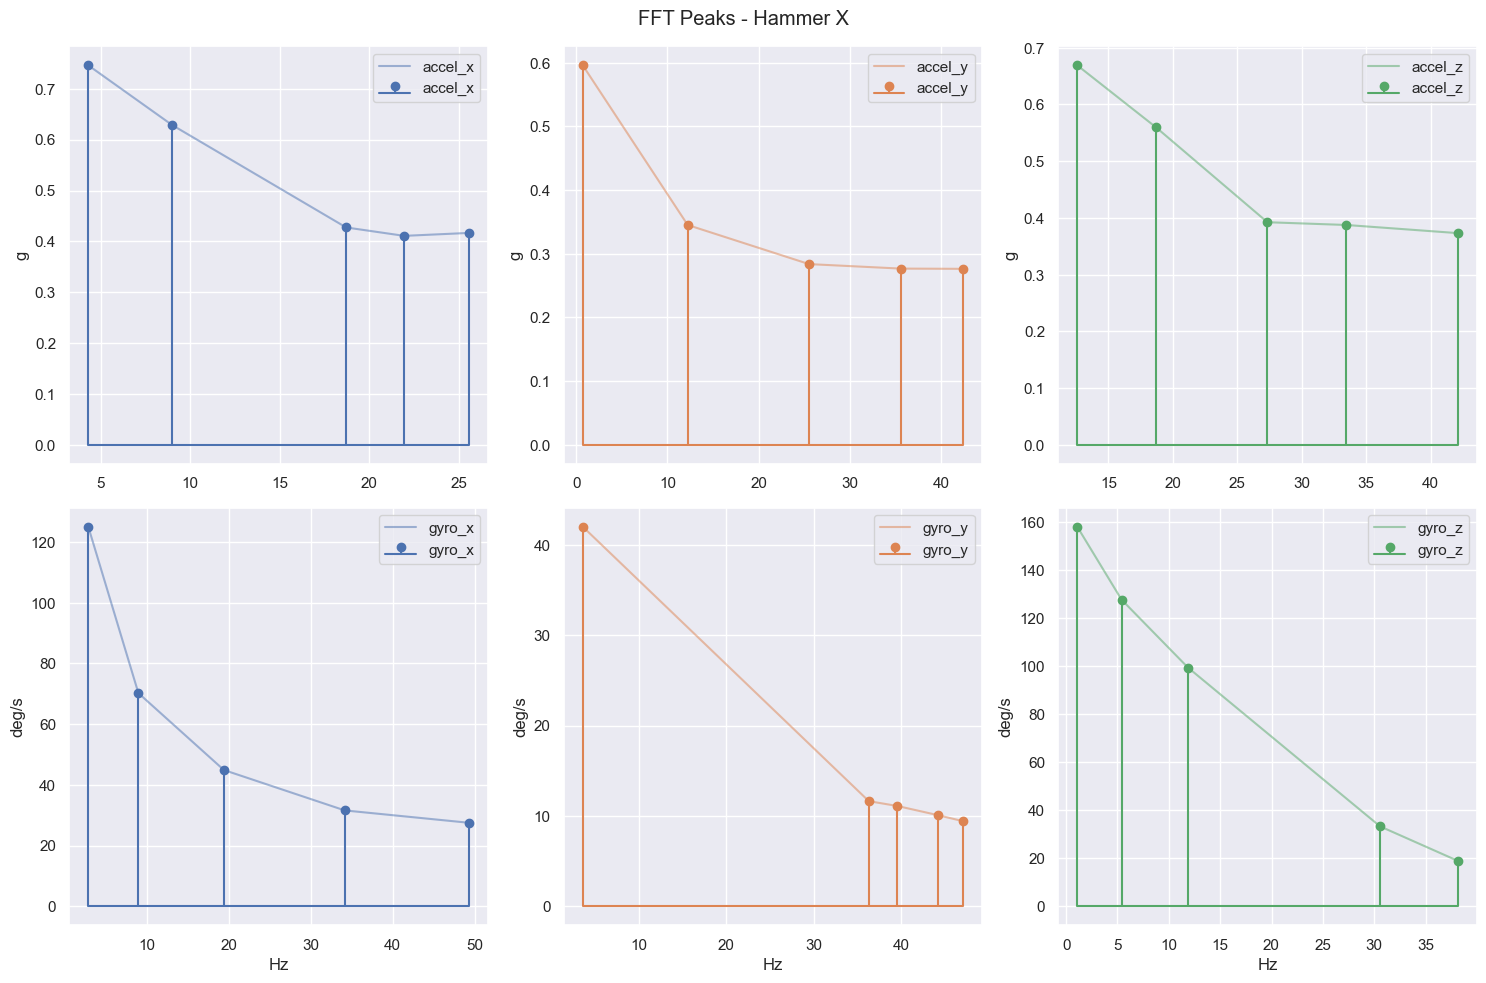

In [13]:
# plot_stem_peaks(ref_fft[100], title="Reference")
# plot_stem_peaks(floatingx_fft, title="Floating X")
# plot_stem_peaks(floatingy_fft, title="Floating Y")
# plot_stem_peaks(floatingz_fft, title="Floating Z")
plot_stem_peaks(hammerx_fft[0], title="Hammer X")
# plot_stem_peaks(hammery_fft[0], title="Hammer Y")
# plot_stem_peaks(hammerz_fft[0], title="Hammer Z")
# plot_stem_peaks(impactx_fft, title="Impact X")
# plot_stem_peaks(impacty_fft, title="Impact Y")
# plot_stem_peaks(impactz_fft, title="Impact Z")
# plot_stem_peaks(rotationx_fft, title="Rotation X")
# plot_stem_peaks(rotationy_fft, title="Rotation Y")
# plot_stem_peaks(rotationz_fft, title="Rotation Z")

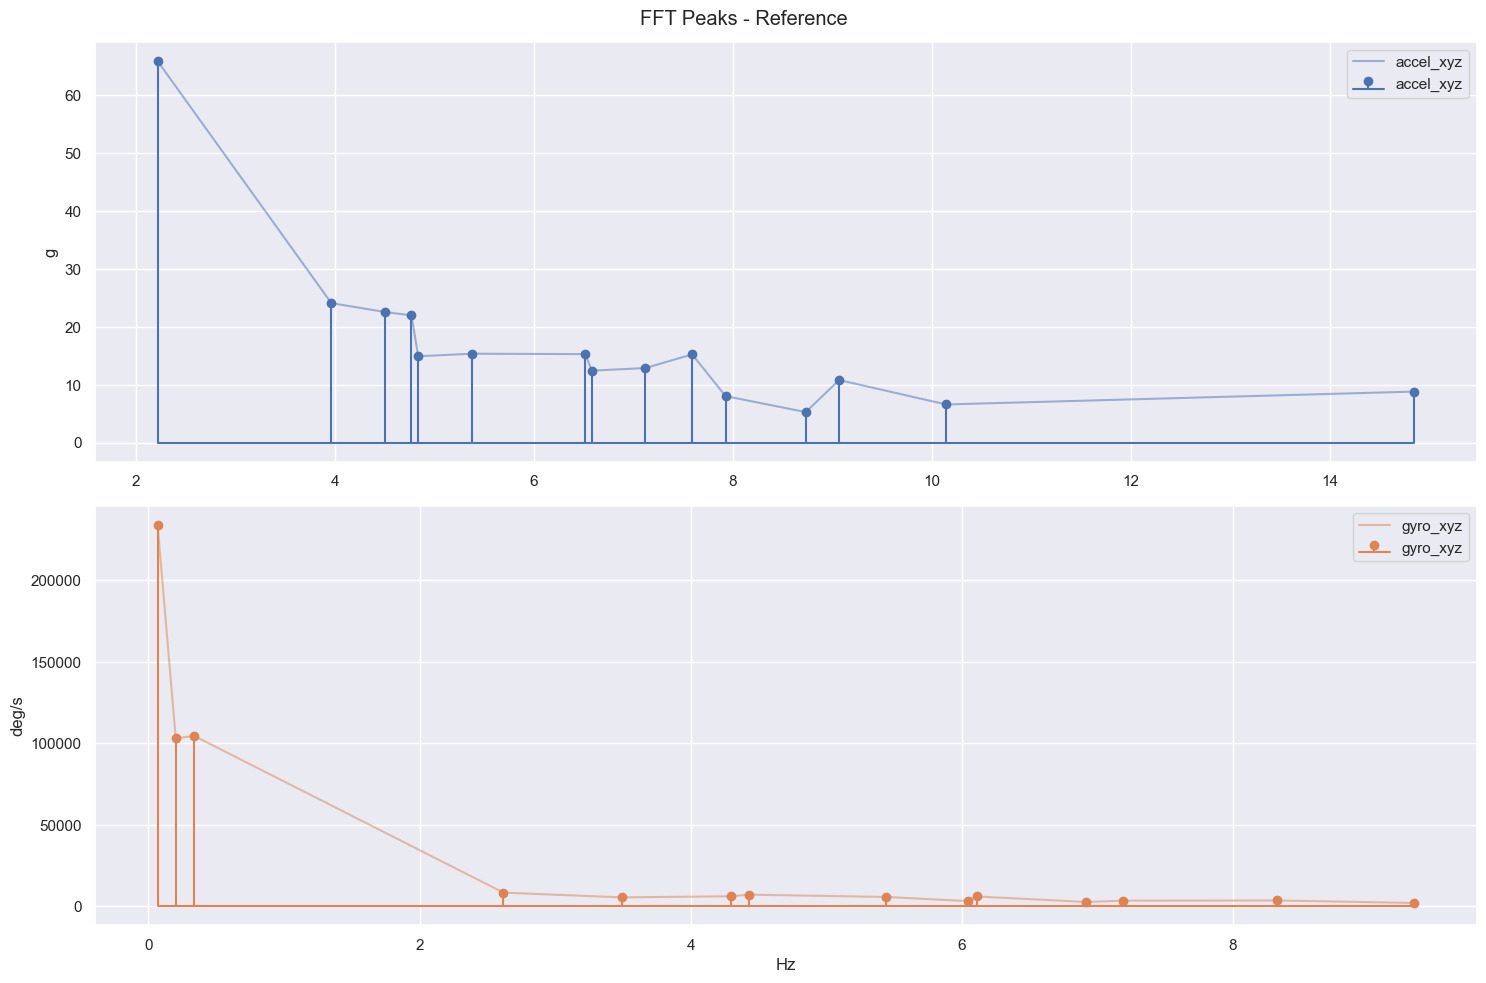

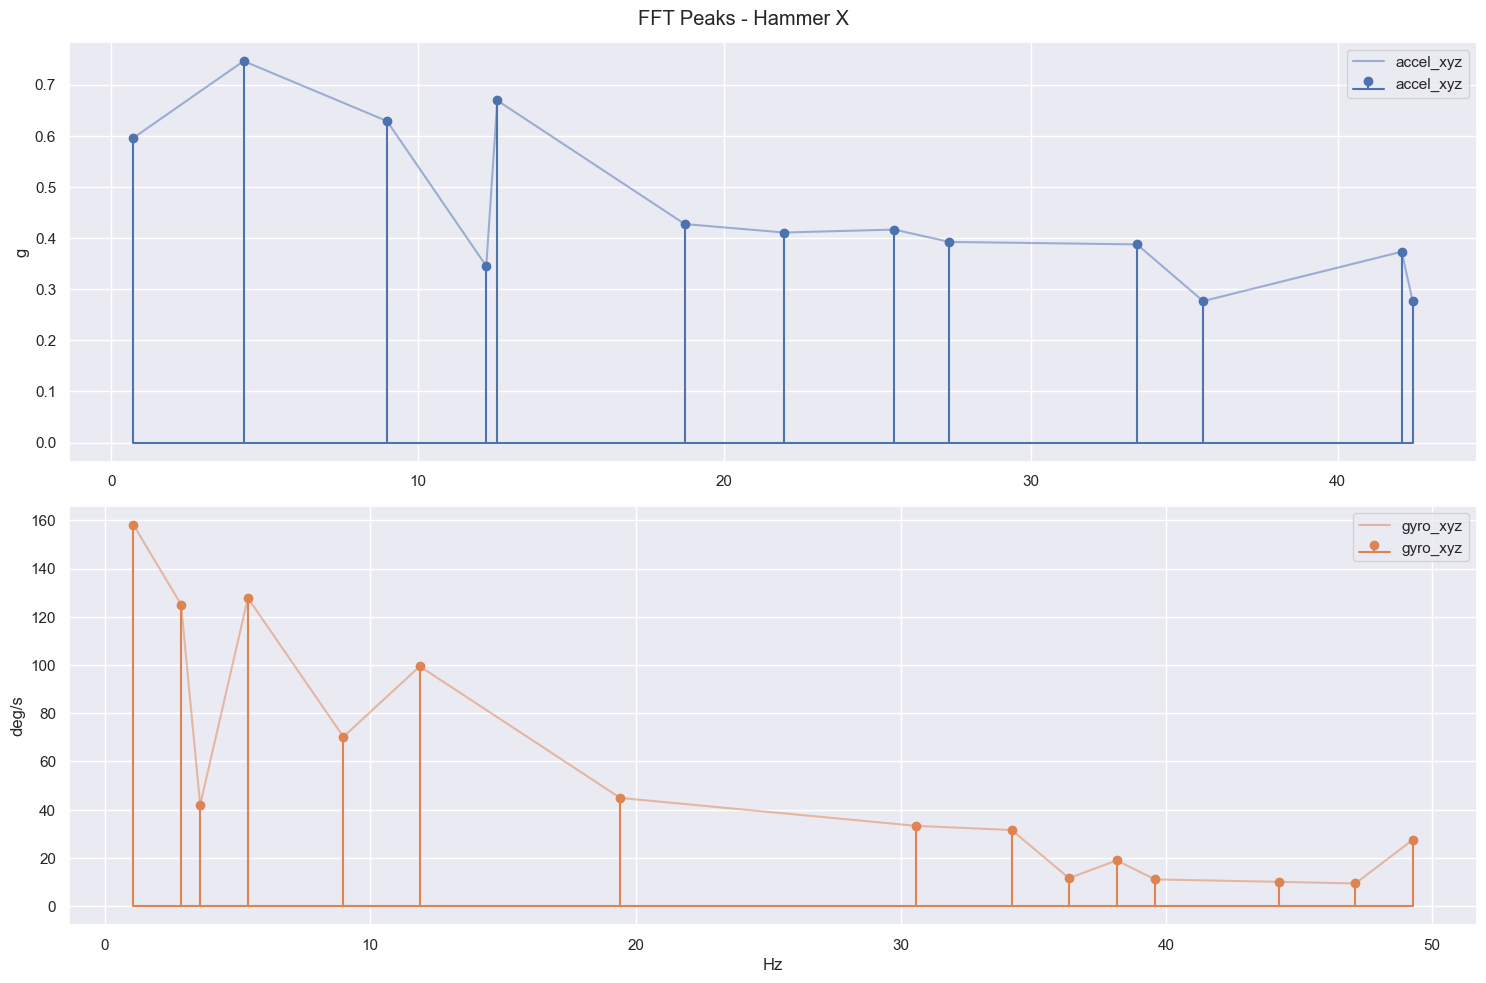

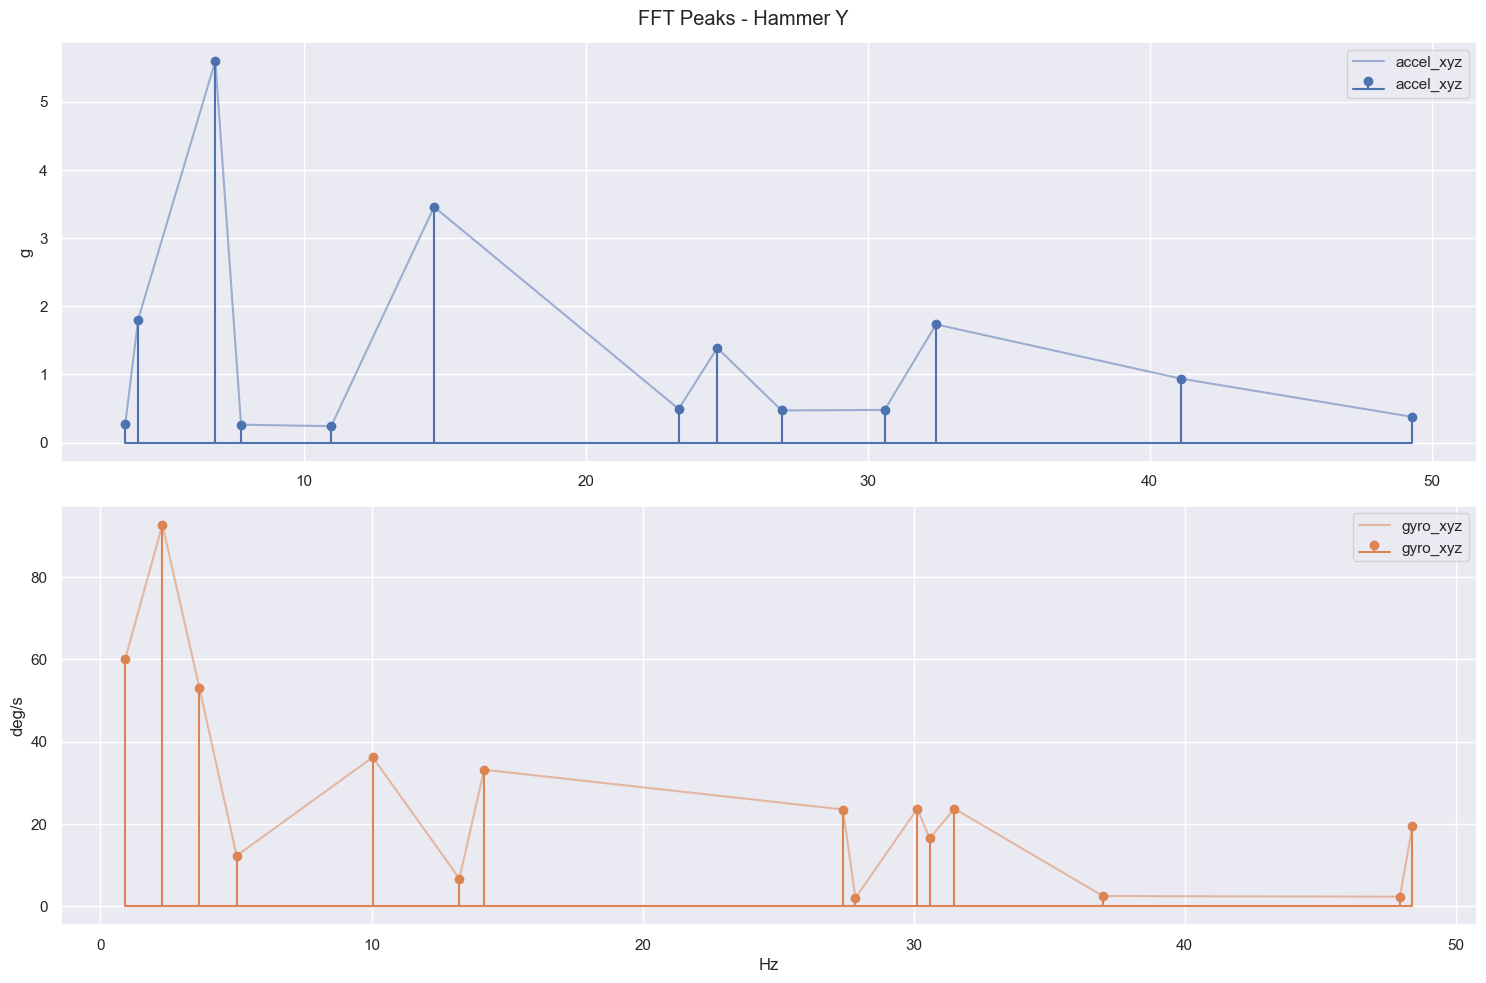

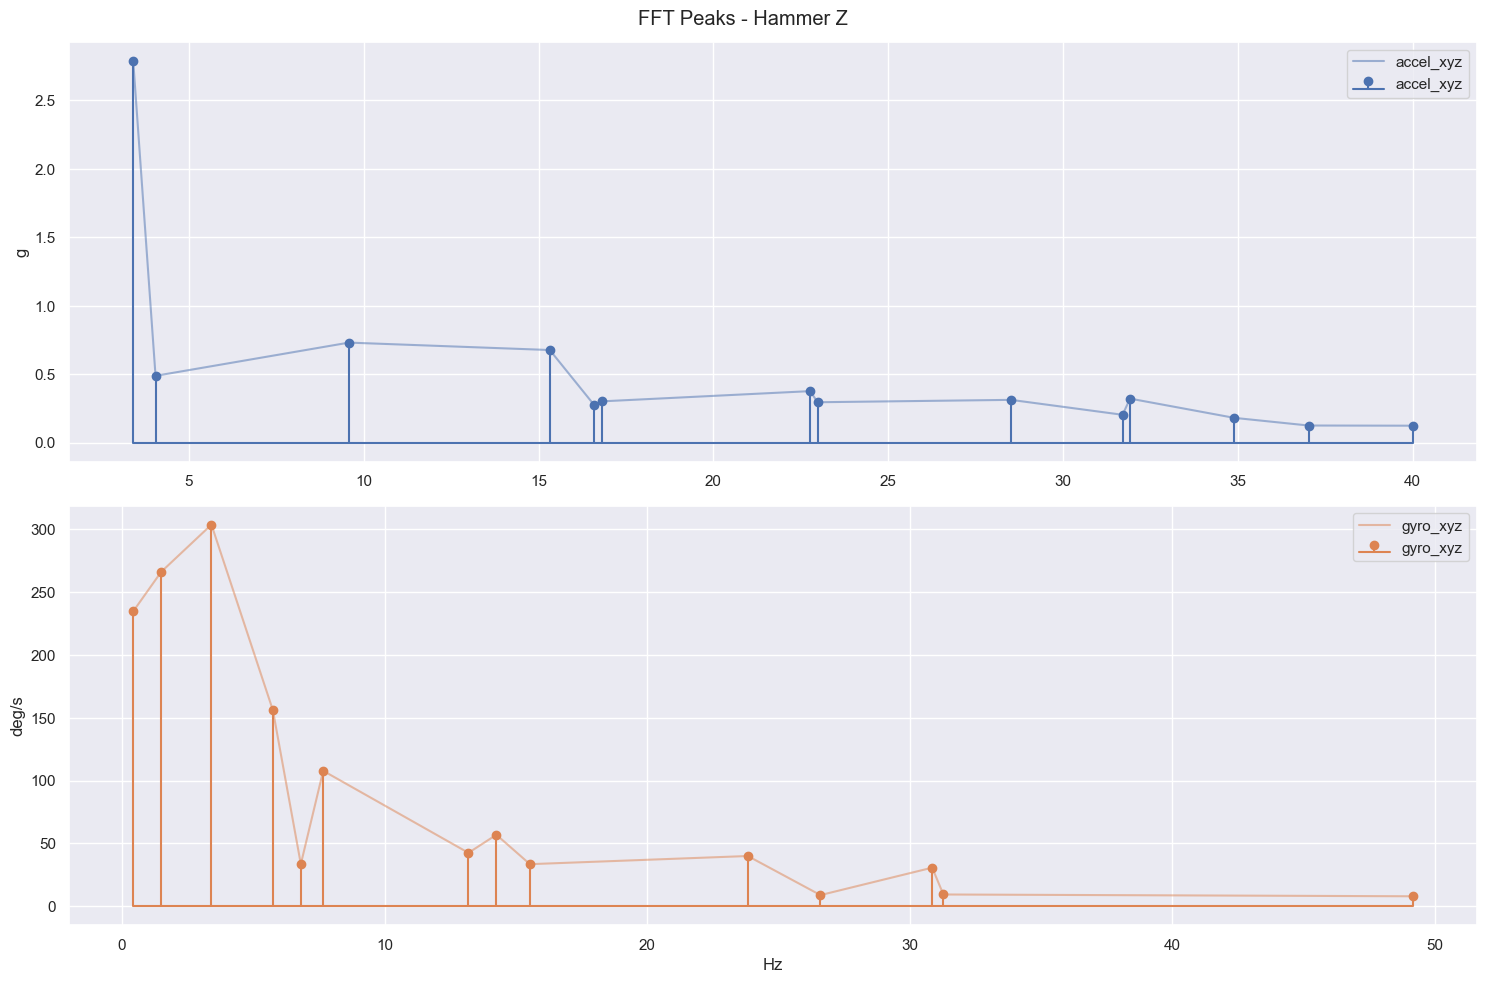

In [14]:
plot_peaks_combined(ref_fft[100], title="Reference")
# plot_peaks_combined(floatingx_fft[0], title="Floating X")
# plot_peaks_combined(floatingy_fft[0], title="Floating Y")
# plot_peaks_combined(floatingz_fft[0], title="Floating Z")
plot_peaks_combined(hammerx_fft[0], title="Hammer X")
plot_peaks_combined(hammery_fft[0], title="Hammer Y")
plot_peaks_combined(hammerz_fft[0], title="Hammer Z")
# plot_peaks_combined(impactx_fft[0], title="Impact X")
# plot_peaks_combined(impacty_fft[0], title="Impact Y")
# plot_peaks_combined(impactz_fft[0], title="Impact Z")
# plot_peaks_combined(rotationx_fft[0], title="Rotation X")
# plot_peaks_combined(rotationy_fft[0], title="Rotation Y")
# plot_peaks_combined(rotationz_fft[0], title="Rotation Z")

In [15]:
accel_floatingx_zip = zip_peaks_freq(floatingx_fft[0]['accel_peaks_freq'], floatingx_fft[0]['accel_peaks'])
gyro_floatingx_zip = zip_peaks_freq(floatingx_fft[0]['gyro_peaks_freq'], floatingx_fft[0]['gyro_peaks'])
accel_floatingy_zip = zip_peaks_freq(floatingy_fft[0]['accel_peaks_freq'], floatingy_fft[0]['accel_peaks'])
gyro_floatingy_zip = zip_peaks_freq(floatingy_fft[0]['gyro_peaks_freq'], floatingy_fft[0]['gyro_peaks'])
accel_floatingz_zip = zip_peaks_freq(floatingz_fft[0]['accel_peaks_freq'], floatingz_fft[0]['accel_peaks'])
gyro_floatingz_zip = zip_peaks_freq(floatingz_fft[0]['gyro_peaks_freq'], floatingz_fft[0]['gyro_peaks'])
accel_hammerx_zip = zip_peaks_freq(hammerx_fft[0]['accel_peaks_freq'], hammerx_fft[0]['accel_peaks'])
gyro_hammerx_zip = zip_peaks_freq(hammerx_fft[0]['gyro_peaks_freq'], hammerx_fft[0]['gyro_peaks'])
accel_hammery_zip = zip_peaks_freq(hammery_fft[0]['accel_peaks_freq'], hammery_fft[0]['accel_peaks'])
gyro_hammery_zip = zip_peaks_freq(hammery_fft[0]['gyro_peaks_freq'], hammery_fft[0]['gyro_peaks'])
accel_hammerz_zip = zip_peaks_freq(hammerz_fft[0]['accel_peaks_freq'], hammerz_fft[0]['accel_peaks'])
gyro_hammerz_zip = zip_peaks_freq(hammerz_fft[0]['gyro_peaks_freq'], hammerz_fft[0]['gyro_peaks'])
accel_impactx_zip = zip_peaks_freq(impactx_fft[0]['accel_peaks_freq'], impactx_fft[0]['accel_peaks'])
gyro_impactx_zip = zip_peaks_freq(impactx_fft[0]['gyro_peaks_freq'], impactx_fft[0]['gyro_peaks'])
accel_impacty_zip = zip_peaks_freq(impacty_fft[0]['accel_peaks_freq'], impacty_fft[0]['accel_peaks'])
gyro_impacty_zip = zip_peaks_freq(impacty_fft[0]['gyro_peaks_freq'], impacty_fft[0]['gyro_peaks'])
accel_impactz_zip = zip_peaks_freq(impactz_fft[0]['accel_peaks_freq'], impactz_fft[0]['accel_peaks'])
gyro_impactz_zip = zip_peaks_freq(impactz_fft[0]['gyro_peaks_freq'], impactz_fft[0]['gyro_peaks'])
accel_rotationx_zip = zip_peaks_freq(rotationx_fft[0]['accel_peaks_freq'], rotationx_fft[0]['accel_peaks'])
gyro_rotationx_zip = zip_peaks_freq(rotationx_fft[0]['gyro_peaks_freq'], rotationx_fft[0]['gyro_peaks'])
accel_rotationy_zip = zip_peaks_freq(rotationy_fft[0]['accel_peaks_freq'], rotationy_fft[0]['accel_peaks'])
gyro_rotationy_zip = zip_peaks_freq(rotationy_fft[0]['gyro_peaks_freq'], rotationy_fft[0]['gyro_peaks'])
accel_rotationz_zip = zip_peaks_freq(rotationz_fft[0]['accel_peaks_freq'], rotationz_fft[0]['accel_peaks'])
gyro_rotationz_zip = zip_peaks_freq(rotationz_fft[0]['gyro_peaks_freq'], rotationz_fft[0]['gyro_peaks'])

sequences_accel = [
    accel_floatingx_zip, accel_floatingy_zip, accel_floatingz_zip,
    accel_hammerx_zip, accel_hammery_zip, accel_hammerz_zip,
    accel_impactx_zip, accel_impacty_zip, accel_impactz_zip,
    accel_rotationx_zip, accel_rotationy_zip, accel_rotationz_zip,
]

sequences_gyro = [
    gyro_floatingx_zip, gyro_floatingy_zip, gyro_floatingz_zip,
    gyro_hammerx_zip, gyro_hammery_zip, gyro_hammerz_zip,
    gyro_impactx_zip, gyro_impacty_zip, gyro_impactz_zip,
    gyro_rotationx_zip, gyro_rotationy_zip, gyro_rotationz_zip,
]

## Data Classification

### Dynamic Time Warping

##### Functions

##### Code

DTW Univariate Distance:  116.94929280090636
DTW Multivariate Distance:  118.0492048365448
DTW Multivariate Normalized Distance:  5.606176161568085


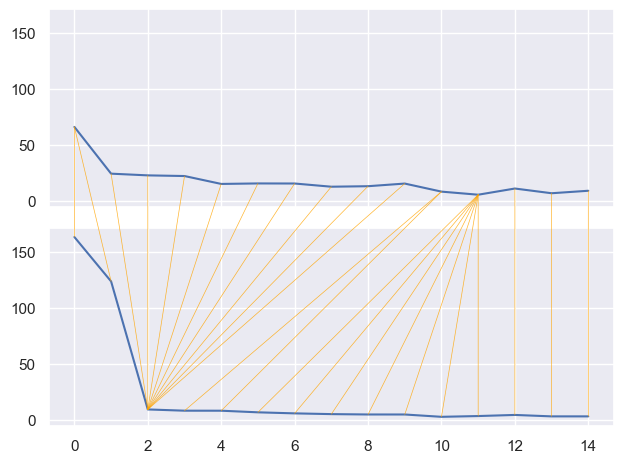

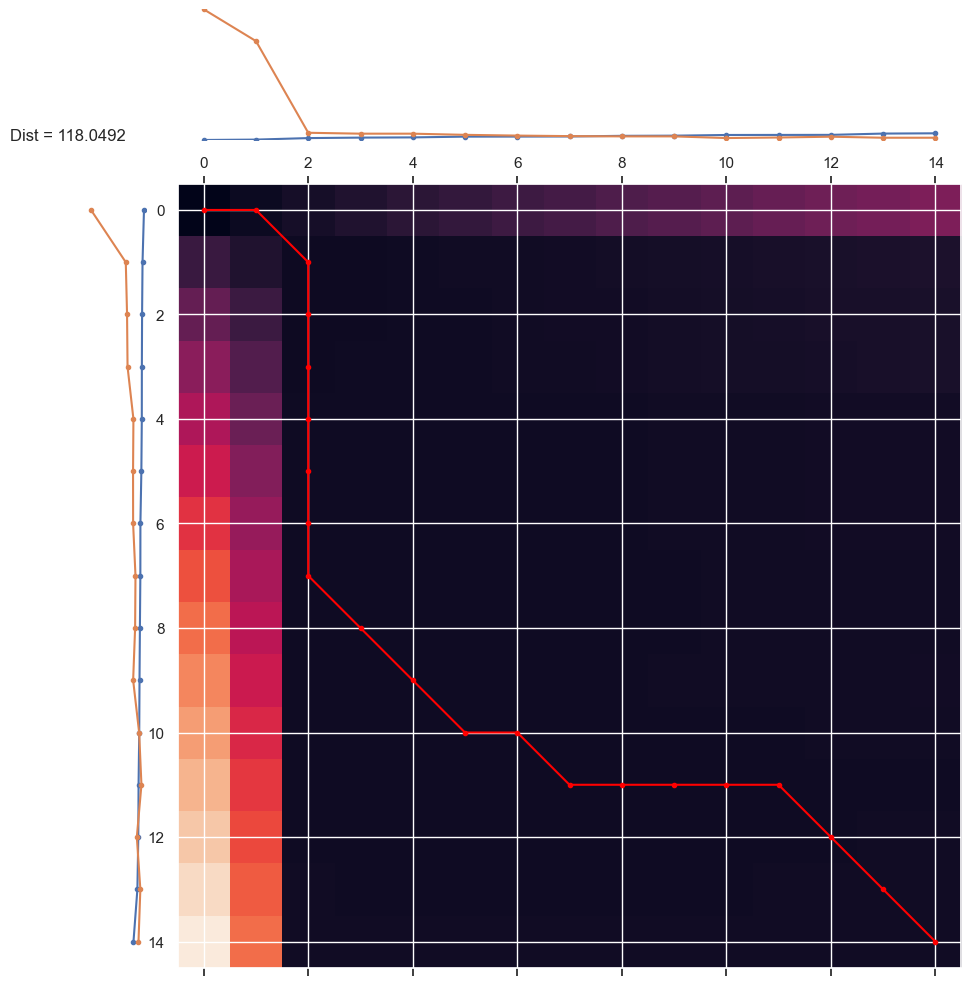

In [16]:
# Calculate the DTW distance between the two sequences
distance = dtw_ndim.distance(ref_fft[100]['accel_peaks'], floatingx_fft[0]['accel_peaks'])
distance_zip = dtw_ndim.distance(zip_peaks_freq(ref_fft[100]['accel_peaks_freq'], ref_fft[100]['accel_peaks']), accel_floatingx_zip)
print("DTW Univariate Distance: ", distance)
print("DTW Multivariate Distance: ", distance_zip)

# plot the univariate warp path
single_path = dtw.warping_path(ref_fft[100]['accel_peaks'], floatingx_fft[0]['accel_peaks'])
dtwvis.plot_warping(ref_fft[100]['accel_peaks'], floatingx_fft[0]['accel_peaks'], single_path)

# plot the cost matrix and the best path
d, paths = dtw_ndim.warping_paths(zip_peaks_freq(ref_fft[100]['accel_peaks_freq'], ref_fft[100]['accel_peaks']), accel_floatingx_zip)
best_path = dtw.best_path(paths)

dtwvis.plot_warpingpaths(zip_peaks_freq(ref_fft[100]['accel_peaks_freq'], ref_fft[100]['accel_peaks']), accel_floatingx_zip, paths, best_path)

# normalize the score by dividing the last value of the best path by the length of the best path
score = paths[best_path[-1][0], best_path[-1][1]] / len(best_path)
print("DTW Multivariate Normalized Distance: ", score)

In [17]:
# calculate the DTW distance between the reference and all the other sequences

best_scores = []
for i in range(len(ref_fft)):

    distances = []
    for j in range(len(sequences_accel)):
        d_accel, paths_accel = dtw_ndim.warping_paths(zip_peaks_freq(ref_fft[i]['accel_peaks_freq'], ref_fft[i]['accel_peaks']), sequences_accel[j])
        d_gyro, paths_gyro = dtw_ndim.warping_paths(zip_peaks_freq(ref_fft[i]['gyro_peaks_freq'], ref_fft[i]['gyro_peaks']), sequences_gyro[j])
        best_path_accel = dtw.best_path(paths_accel)
        best_path_gyro = dtw.best_path(paths_gyro)
        if len(best_path_accel) == 0 or len(best_path_gyro) == 0:
            score = 99999999
        else:

            score_accel = paths_accel[best_path_accel[-1][0], best_path_accel[-1][1]] / len(best_path_accel)
            score_gyro = paths_gyro[best_path_gyro[-1][0], best_path_gyro[-1][1]] / len(best_path_gyro)
            score = score_accel + score_gyro
            # score = d_accel + d_gyro
        distances.append(score)
    # print(distances)
    best_score = [min(distances), distances.index(min(distances))]
    # print(f"Best score: {best_score[0]} with sequence {best_score[1]}")

    best_scores.append(best_score)

print(best_scores)


[[134.466442651875, 5], [139.1239051452981, 5], [139.92698858419985, 5], [140.9429583115478, 5], [151.0289593425319, 5], [142.69864839331177, 5], [148.60691503413872, 5], [193.29122451664648, 5], [278.19895549367374, 5], [277.583124866213, 6], [285.82628379634906, 5], [282.7395464517447, 5], [346.5462636016786, 5], [276.7209018636205, 6], [151.84414404123288, 6], [178.63844120173943, 7], [257.2486121272857, 7], [245.66712170827526, 11], [223.53489602663674, 11], [406.7878281567905, 7], [435.36656304918193, 7], [411.2587822013535, 11], [387.7523225651858, 11], [386.5867105869377, 11], [382.19093018593895, 11], [366.80976214993046, 11], [365.8750084966524, 11], [388.0449152043129, 11], [400.14672467673176, 11], [425.55135713278383, 11], [388.18654315615345, 11], [378.4652440581213, 11], [346.0041755013322, 11], [419.3276555157867, 11], [430.12363252499034, 11], [214.68987102931194, 11], [227.3468834468357, 11], [504.46553276361743, 11], [746.3830438557208, 11], [1162.512273006449, 9], [1

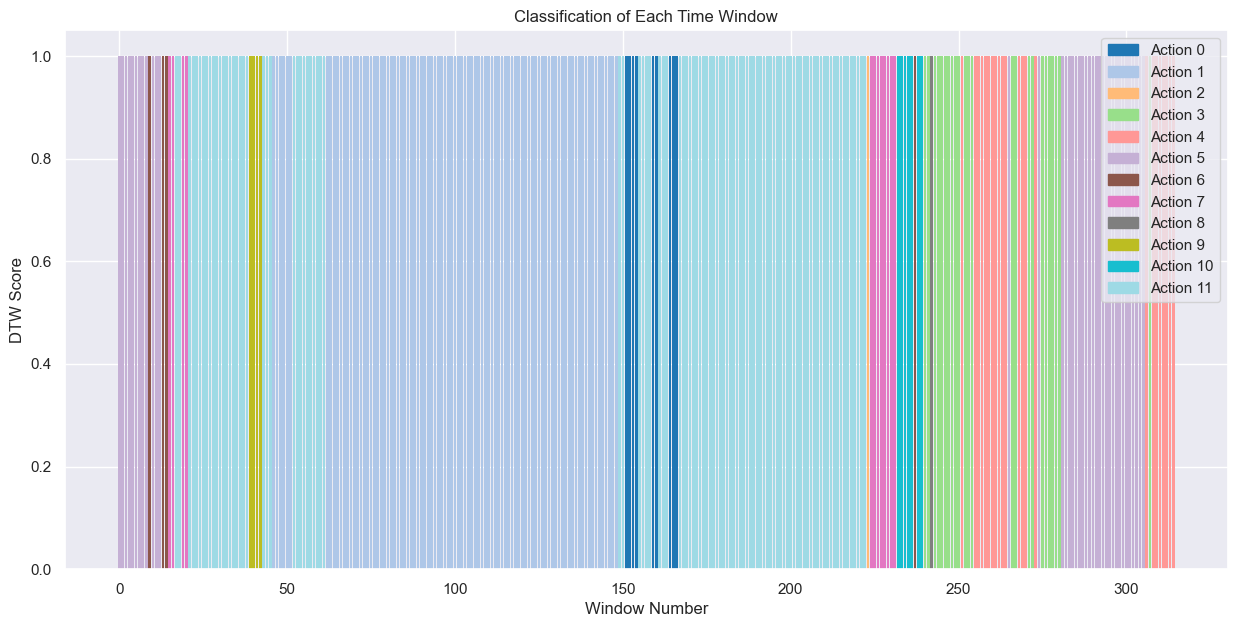

In [18]:
# Step 1: Extract classifications from best_scores
classifications = [item[1] for item in best_scores]

# Step 2: Generate a unique color for each classification
unique_classifications = list(set(classifications))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classifications)))  # Using 'tab20' for more distinct colors
color_map = dict(zip(unique_classifications, colors))

# Step 3: Plotting the histogram with height of 1.0 for each bar
plt.figure(figsize=(15, 7))
for i, classification in enumerate(classifications):
    plt.bar(i, 1.0, color=color_map[classification], edgecolor='None')

# Step 4: Creating the legend
legend_handles = [mpatches.Patch(color=color_map[cls], label=f'Action {cls}') for cls in unique_classifications]
plt.legend(handles=legend_handles)

# Step 5: Setting up the axes and labels
plt.xlabel("Window Number")
plt.ylabel("DTW Score")
plt.title("Classification of Each Time Window")
# plt.xticks(range(len(scores)))  # Set x-ticks to be the window numbers

plt.show()


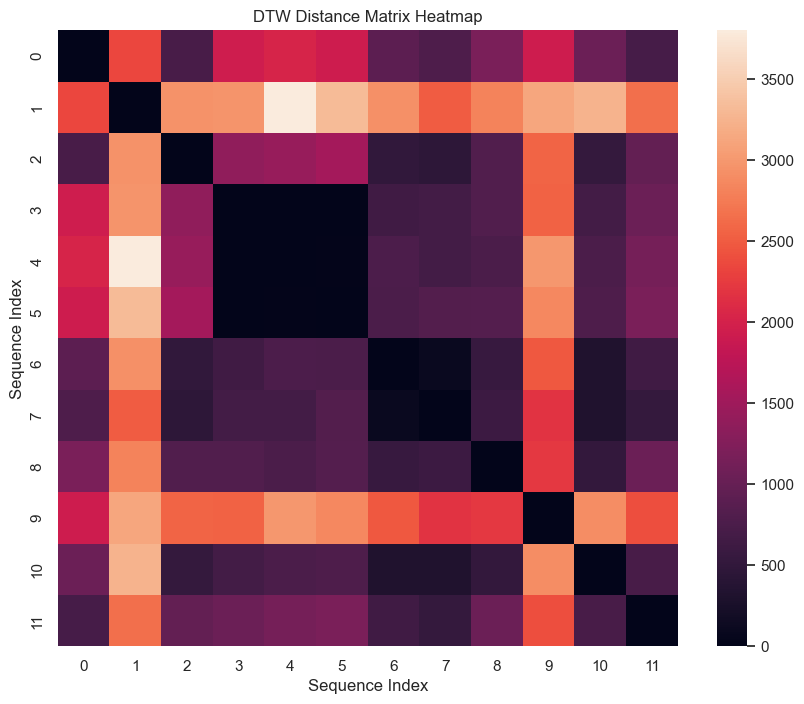

In [19]:

# Initialize a 12x12 matrix of zeros for the distances
distance_matrix = np.zeros((len(sequences_accel), len(sequences_accel)))

# Calculate the DTW distance between each pair of sequences
for i in range(len(sequences_accel)):
    for j in range(len(sequences_accel)):
        if i != j:  # No need to calculate when i == j since the distance is zero
            d_accel, paths_accel = dtw_ndim.warping_paths(sequences_accel[i], sequences_accel[j])
            d_gyro, paths_gyro = dtw_ndim.warping_paths(sequences_gyro[i], sequences_gyro[j])
            best_path_accel = dtw.best_path(paths_accel)
            best_path_gyro = dtw.best_path(paths_gyro)
            if len(best_path_accel) == 0 or len(best_path_gyro) == 0:
                score = 99999999
            else:

                score_accel = paths_accel[best_path_accel[-1][0], best_path_accel[-1][1]] / len(best_path_accel)
                score_gyro = paths_gyro[best_path_gyro[-1][0], best_path_gyro[-1][1]] / len(best_path_gyro)
                score = score_accel + score_gyro

            distance_matrix[i, j] = score

# Now, create a heatmap from the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=False, fmt=".2f")
plt.title('DTW Distance Matrix Heatmap')
plt.xlabel('Sequence Index')
plt.ylabel('Sequence Index')
plt.show()

In [20]:
# spettrogramma